In [1]:
#!/usr/bin/env python
# # -*- coding: utf-8 -*-
#!/usr/bin/env python
#!pip install tensorflow==1.15

import numpy as np
import matplotlib.pyplot as plt
import pickle
import glob, os, inspect
import argparse
import time
import seaborn as sns
# import matplotlib
# matplotlib.use("Qt5Agg")
# #matplotlib.use('Agg')
# from mpl_toolkits.mplot3d import axes3d
# import matplotlib.pyplot as plt
import pandas as pd
import sys,inspect
sys.path.append("C:\\Users\\Vinamr J\\Documents\\qic\\qrc\\hqr\\hqr-master\\chaos\\Postprocess")
sys.path.append("C:\\Users\\Vinamr J\\Documents\\qic\\qrc\\hqr\\hqr-master\\chaos\\Methods\\Models\\Utils")

import utils  # for utils.py
from utils import *
import global_utils  # for global_utils.py

# import utils
# from utils import *
# import sys
# sys.path.append('../Methods/Models/Utils')
# import global_utils

In [2]:
sysname, tidx = "SST", 2
file_path = os.path.abspath("HQRC_analysis.ipynb")
current_directory = os.path.dirname(file_path)
mid_directory = os.path.dirname(current_directory)
parent_directory = os.path.dirname(mid_directory)

print("Current Directory:", current_directory)
print("Parent Directory:", parent_directory)

#current_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
results_dir = os.path.join(os.path.dirname(mid_directory), "Results")  # Use os.path.join for path concatenation
print(results_dir)

eval_path = os.path.join(results_dir, sysname, 'Evaluation_Data')
print(eval_path)

model_path = os.path.join(results_dir, sysname, 'Trained_Models')
print(model_path)

fig_path = os.path.join(results_dir, sysname, 'Eval_Figures')
if not os.path.isdir(fig_path):
    os.makedirs(fig_path)  # Use os.makedirs to create parent directories if needed
print(fig_path)

Current Directory: c:\Users\Vinamr J\Documents\qic\qrc\hqr\hqr-master\chaos\Data\SST
Parent Directory: c:\Users\Vinamr J\Documents\qic\qrc\hqr\hqr-master\chaos
c:\Users\Vinamr J\Documents\qic\qrc\hqr\hqr-master\chaos\Results
c:\Users\Vinamr J\Documents\qic\qrc\hqr\hqr-master\chaos\Results\SST\Evaluation_Data
c:\Users\Vinamr J\Documents\qic\qrc\hqr\hqr-master\chaos\Results\SST\Trained_Models
c:\Users\Vinamr J\Documents\qic\qrc\hqr\hqr-master\chaos\Results\SST\Eval_Figures


In [3]:
models = []
samples = []
size_values = [80,120,250,500,1000,2000]
layer_values = [1,2]
hspl_values = [50,60,70]
sl_values = [16,20]
for size in size_values:
    for layers in layer_values:
        for hspl in hspl_values:
            for sl in sl_values:
                string1 = f"RNN-lstm-RDIM_5-N_used_427-NLAY_{layers}-SLAY_{size}-ISH_statefull-SL_{sl}-PL_{sl}-LR_0.001-DKP_1.0-ZKP_1.0-HSPL_{hspl}-IPL_300-NL_0-NICS_3"
                string2 = f"LSTM-{size}-({layers})-HSPL-{hspl}-SL-{sl}"
                models.append([os.path.join(eval_path,string1),string2])
                samples.append(string2)
title = "Sea Surface Temperatures"

In [4]:
rmse_dict = dict()
targets = dict()
outputs = dict()
targets_train = dict()
outputs_train = dict()
sp_outputs = dict()
sp_targets = dict()
Wouts = dict()
coeffs = dict()
rmnse_avg_train_dict = dict()
rmnse_avg_test_dict = dict()
for i in range(len(models)):
    rfolder, label = models[i][0], models[i][1]
    fname = os.path.join(rfolder, 'results.pickle')
    if os.path.isfile(fname):
        with open(fname, 'rb') as rfile:
            try:
                rs = pickle.load(rfile)
            except:
                continue
            #print(rs.keys())
            qs = QResults()
            qs.rmnse_avg_test = rs['rmnse_avg_TEST']
            qs.rmnse_avg_train = rs['rmnse_avg_TRAIN']
            qs.n_pred_005_avg_test = rs['num_accurate_pred_005_avg_TEST']
            qs.n_pred_005_avg_train = rs['num_accurate_pred_005_avg_TRAIN']
            qs.n_pred_050_avg_test = rs['num_accurate_pred_050_avg_TEST']
            qs.n_pred_050_avg_train = rs['num_accurate_pred_050_avg_TRAIN']
            qs.model_name = rs['model_name']
            #if qs.rmnse_avg_test != np.inf and qs.rmnse_avg_train != np.inf:
                #print(rs.keys())
            #print(qs.model_name)
            #print('train={}, test={}'.format(qs.rmnse_avg_train, qs.rmnse_avg_test))
            #qs.info()
            rmnse_avg_train_dict[label] = rs['rmnse_avg_TRAIN']
            rmnse_avg_test_dict[label] = rs['rmnse_avg_TEST']
            pred_test = rs['predictions_all_TEST']
            truth_test = rs['truths_all_TEST']
            pred_train = rs['predictions_all_TRAIN']
            truth_train =rs['truths_all_TRAIN']
            print(pred_test.shape)
            M = len(pred_test)
            print('{} Number of test'.format(qs.model_name), M)
            rmsels = []
            for j in range(M):
                    rmsels.append(calNRMSE(pred_test[j], truth_test[j]))

            rmse_dict[label] = np.mean(np.array(rmsels), axis=0)
            print(rmse_dict[label].shape)


            targets[label] = truth_test[0] #0th test 
            outputs[label] = pred_test[0]

            targets_train[label] = truth_train[0] #0th test 
            outputs_train[label] = pred_train[0]
            # For frequency
            sp_outputs[label] = rs['sp_pred_TEST']
            sp_targets[label] = rs['sp_true_TEST']
    else:
        print('Not found {}'.format(fname))
    # if trained_models is not None:
    #     rfolder, label = trained_models[i][0], trained_models[i][1]
    #     fname = os.path.join(rfolder, 'data.pickle')
    #     if os.path.isfile(fname):
    #         print('File existed: ', fname)
    #         with open(fname, 'rb') as rfile:
    #             #try:
    #             rs = pickle.load(rfile)
    #             #except:
    #             #    continue
    #             print(rs.keys())
    #             coeffs[label] = np.array(rs['coeffs'])
    #             Wouts[label]  = rs['W_out'][:-1].reshape((coeffs[label].shape[0], -1))
    #             print(Wouts[label].shape, coeffs[label].shape)
    #     else:
    #         print('Not found saved model {}'.format(fname))

(3, 300, 5)
RNN-lstm-RDIM_5-N_used_427-NLAY_1-SLAY_80-ISH_statefull-SL_16-PL_16-LR_0.001-DKP_1.0-ZKP_1.0-HSPL_50-IPL_300-NL_0-NICS_3 Number of test 3
(300,)
(3, 300, 5)
RNN-lstm-RDIM_5-N_used_427-NLAY_1-SLAY_80-ISH_statefull-SL_20-PL_20-LR_0.001-DKP_1.0-ZKP_1.0-HSPL_50-IPL_300-NL_0-NICS_3 Number of test 3
(300,)
(3, 300, 5)
RNN-lstm-RDIM_5-N_used_427-NLAY_1-SLAY_80-ISH_statefull-SL_16-PL_16-LR_0.001-DKP_1.0-ZKP_1.0-HSPL_60-IPL_300-NL_0-NICS_3 Number of test 3
(300,)
(3, 300, 5)
RNN-lstm-RDIM_5-N_used_427-NLAY_1-SLAY_80-ISH_statefull-SL_20-PL_20-LR_0.001-DKP_1.0-ZKP_1.0-HSPL_60-IPL_300-NL_0-NICS_3 Number of test 3
(300,)
(3, 300, 5)
RNN-lstm-RDIM_5-N_used_427-NLAY_1-SLAY_80-ISH_statefull-SL_16-PL_16-LR_0.001-DKP_1.0-ZKP_1.0-HSPL_70-IPL_300-NL_0-NICS_3 Number of test 3
(300,)
(3, 300, 5)
RNN-lstm-RDIM_5-N_used_427-NLAY_1-SLAY_80-ISH_statefull-SL_20-PL_20-LR_0.001-DKP_1.0-ZKP_1.0-HSPL_70-IPL_300-NL_0-NICS_3 Number of test 3
(300,)
(3, 300, 5)
RNN-lstm-RDIM_5-N_used_427-NLAY_2-SLAY_80-ISH_

In [5]:
#Manually calculated ignore
model_test_error = []
test_avg_error = []
for label in samples:
    model_test_error.append([label,np.mean(rmse_dict[label])])
    test_avg_error.append(np.mean(rmse_dict[label]))
print(model_test_error)
print("Test Average error = ",np.mean(test_avg_error))

[['LSTM-80-(1)-HSPL-50-SL-16', 1.3500275103126398], ['LSTM-80-(1)-HSPL-50-SL-20', 1.2914603397164526], ['LSTM-80-(1)-HSPL-60-SL-16', 1.6206845647448826], ['LSTM-80-(1)-HSPL-60-SL-20', 1.222310509157348], ['LSTM-80-(1)-HSPL-70-SL-16', 1.2308108755147427], ['LSTM-80-(1)-HSPL-70-SL-20', 1.2451064736233952], ['LSTM-80-(2)-HSPL-50-SL-16', 1.5684258579467412], ['LSTM-80-(2)-HSPL-50-SL-20', 1.2977489312438626], ['LSTM-80-(2)-HSPL-60-SL-16', 1.2173753394780404], ['LSTM-80-(2)-HSPL-60-SL-20', 1.364764839095403], ['LSTM-80-(2)-HSPL-70-SL-16', 1.4956796724171018], ['LSTM-80-(2)-HSPL-70-SL-20', 1.3883744131617386], ['LSTM-120-(1)-HSPL-50-SL-16', 1.2114983842647409], ['LSTM-120-(1)-HSPL-50-SL-20', 1.2788335369997728], ['LSTM-120-(1)-HSPL-60-SL-16', 1.3458167625280217], ['LSTM-120-(1)-HSPL-60-SL-20', 1.3479848780262216], ['LSTM-120-(1)-HSPL-70-SL-16', 1.2278448564295972], ['LSTM-120-(1)-HSPL-70-SL-20', 1.544677483668905], ['LSTM-120-(2)-HSPL-50-SL-16', 1.3626515528974468], ['LSTM-120-(2)-HSPL-50-SL-

In [6]:
print(rmnse_avg_train_dict)
print(rmnse_avg_test_dict)
error_array_test = []
error_array_train = []
for label in samples:
    error_array_train.append(rmnse_avg_train_dict[label])
    error_array_test.append(rmnse_avg_test_dict[label])
print("Train average error for HQRC =", np.mean(error_array_train))
print("Test average error for HQRC =", np.mean(error_array_test))

{'LSTM-80-(1)-HSPL-50-SL-16': 0.4922161257854262, 'LSTM-80-(1)-HSPL-50-SL-20': 0.43867693058755397, 'LSTM-80-(1)-HSPL-60-SL-16': 1.1082828586306657, 'LSTM-80-(1)-HSPL-60-SL-20': 0.6431467032918807, 'LSTM-80-(1)-HSPL-70-SL-16': 0.23125816253822407, 'LSTM-80-(1)-HSPL-70-SL-20': 0.43876400995190656, 'LSTM-80-(2)-HSPL-50-SL-16': 0.7810223806829829, 'LSTM-80-(2)-HSPL-50-SL-20': 0.6297884953672992, 'LSTM-80-(2)-HSPL-60-SL-16': 0.45478822705635114, 'LSTM-80-(2)-HSPL-60-SL-20': 0.48165359260905544, 'LSTM-80-(2)-HSPL-70-SL-16': 0.5996796341797199, 'LSTM-80-(2)-HSPL-70-SL-20': 0.45213305628546413, 'LSTM-120-(1)-HSPL-50-SL-16': 0.324058578803786, 'LSTM-120-(1)-HSPL-50-SL-20': 0.40623504242901276, 'LSTM-120-(1)-HSPL-60-SL-16': 0.852476721608991, 'LSTM-120-(1)-HSPL-60-SL-20': 0.6249720745460825, 'LSTM-120-(1)-HSPL-70-SL-16': 0.2921629741784955, 'LSTM-120-(1)-HSPL-70-SL-20': 0.8403683379229844, 'LSTM-120-(2)-HSPL-50-SL-16': 0.6545728760123012, 'LSTM-120-(2)-HSPL-50-SL-20': 0.38327457506278784, 'LSTM

In [7]:
#Sort the dictionary by its values
sorted_rmnse_train = sorted(rmnse_avg_train_dict.items(), key=lambda item: item[1])

#Extract the top 5 keys with the lowest values
#top_5_models_train = [key for key, value in sorted_rmnse_train[:5]]
top_5_models_train = dict(sorted_rmnse_train[:5])
print("Top 5 models with the lowest RMNSE values for training data:", top_5_models_train)

Top 5 models with the lowest RMNSE values for training data: {'LSTM-80-(1)-HSPL-70-SL-16': 0.23125816253822407, 'LSTM-120-(1)-HSPL-70-SL-16': 0.2921629741784955, 'LSTM-2000-(1)-HSPL-50-SL-20': 0.322965019070309, 'LSTM-120-(1)-HSPL-50-SL-16': 0.324058578803786, 'LSTM-250-(1)-HSPL-70-SL-16': 0.3513240440470818}


In [8]:
# Step 1: Sort the dictionary by its values
sorted_rmnse_test = sorted(rmnse_avg_test_dict.items(), key=lambda item: item[1])

# Step 2: Extract the top 5 keys with the lowest values
#top_5_models_train = [key for key, value in sorted_rmnse_train[:5]]
top_5_models_test = dict(sorted_rmnse_test[:5])
print("Top 5 models with the lowest RMNSE values for test data:", top_5_models_test)

Top 5 models with the lowest RMNSE values for test data: {'LSTM-500-(2)-HSPL-60-SL-16': 0.8881146163189737, 'LSTM-500-(2)-HSPL-50-SL-20': 0.9129422748064829, 'LSTM-250-(2)-HSPL-70-SL-16': 0.9718072930250792, 'LSTM-120-(1)-HSPL-50-SL-16': 0.9781562758662407, 'LSTM-80-(1)-HSPL-70-SL-16': 0.9859691202455335}


In [9]:
predictions = []
truths = []
for keys in top_5_models_train:
    predictions.append(outputs_train[keys])
    truths.append(targets_train[keys])
mean_train_predictions = np.mean(predictions, axis=0)
std_train_predictions = np.std(predictions, axis=0)
print("Mean predictions shape:", mean_train_predictions.shape)
print("Standard deviation shape:", std_train_predictions.shape)
print("Mean predictions:\n", mean_train_predictions)
print("Standard deviation:\n", std_train_predictions)
mean_train_truths = np.mean(truths, axis=0)
std_train_truths = np.std(truths, axis=0)
# print("Mean predictions shape:", mean_truths.shape)
# print("Standard deviation shape:", std_truths.shape)
# print("Mean predictions:\n", mean_truths)
# print("Standard deviation:\n", std_truths)

Mean predictions shape: (300, 5)
Standard deviation shape: (300, 5)
Mean predictions:
 [[-398.63954937  -57.4523078    74.28419856    4.54707435   22.68010742]
 [-426.88392169  -49.66624444   86.42751711    5.50486518   18.86464556]
 [-449.45684743  -41.39029793   94.38864391    6.21755889   14.81659049]
 ...
 [ 490.61388362  -65.94194031   31.79095299   19.51813808  -43.20982308]
 [ 452.63520839  -72.78228751    6.22050346   19.47858234  -42.93927446]
 [ 407.96045813  -78.71121681  -20.08734898   18.33031864  -41.82685776]]
Standard deviation:
 [[ 8.15663362  1.23274365  1.73213076  3.32413067  2.2517062 ]
 [ 9.37044948  1.44456074  1.79020024  3.11429932  2.44978072]
 [ 9.91246432  1.81560733  2.05655004  2.84284428  2.52386152]
 ...
 [52.55250253  8.27974294 37.23246604  8.85719465 18.56390989]
 [60.67984205  7.6224948  38.58991779  9.77103759 18.30611586]
 [65.88712064  7.78456736 37.76708907 10.45185221 18.14001129]]


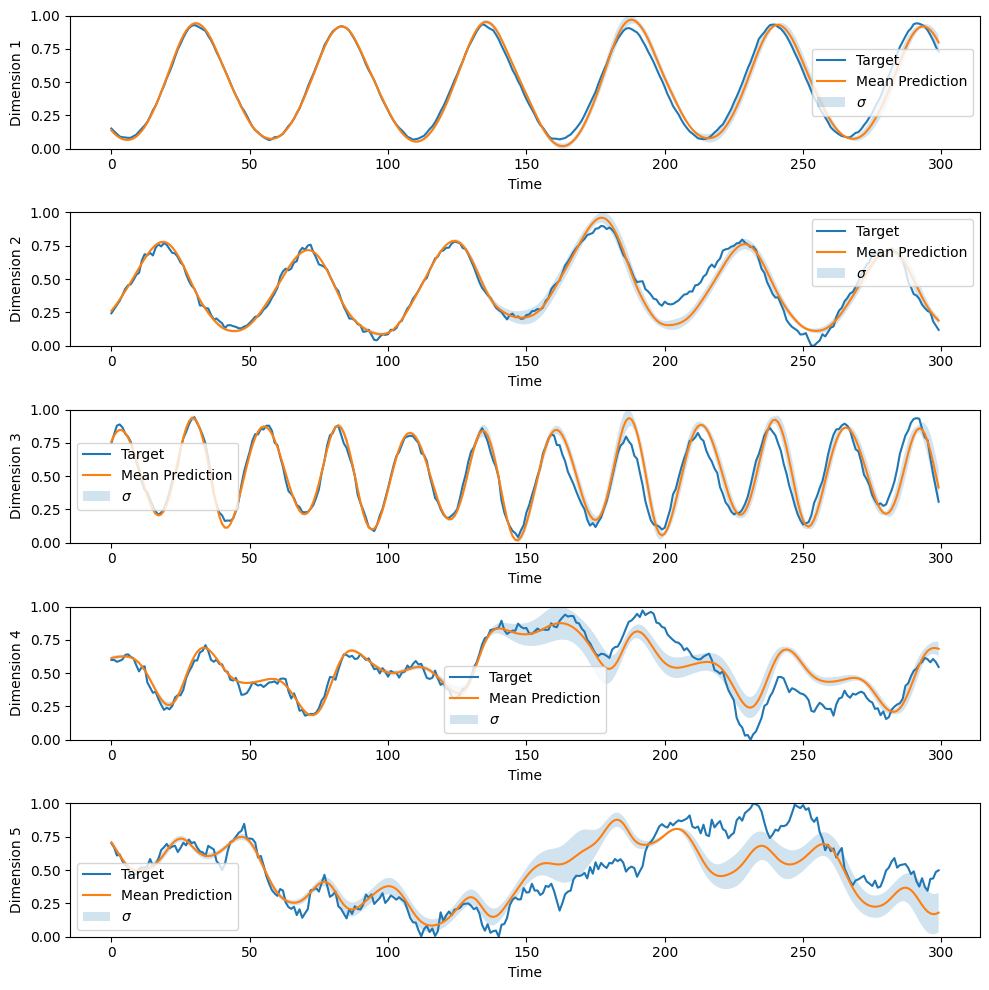

In [10]:
num_dimensions = mean_train_truths.shape[1]
# Create subplots
fig, axs = plt.subplots(num_dimensions, 1, figsize=(10, 10))

# Iterate over each dimension
for dim in range(num_dimensions):
    # Extract arrays for the current dimension
    target_dim = mean_train_truths[:, dim]
    out_dim = mean_train_predictions[:, dim]
    std_dim = std_train_predictions[:, dim]

    # Calculate min and max values across all arrays for current dimension
    data_min = min(np.min(target_dim), np.min(out_dim - std_dim))
    data_max = max(np.max(target_dim), np.max(out_dim + std_dim))

    # Normalize arrays to [0, 1] range
    target_dim = (target_dim - data_min) / (data_max - data_min)
    out_dim = (out_dim - data_min) / (data_max - data_min)
    std_dim = std_dim / (data_max - data_min)  # std deviation is normalized accordingly

    # Plot target and output arrays
    axs[dim].plot(target_dim, label='Target')
    axs[dim].plot(out_dim, label='Mean Prediction')
    axs[dim].fill_between(range(len(out_dim)), out_dim - std_dim, out_dim + std_dim, alpha=0.2, label=r'$\sigma$')

    # Set y-axis limits to [0, 1]
    axs[dim].set_ylim(0, 1)

    # Add labels and legend
    axs[dim].set_xlabel('Time')
    axs[dim].set_ylabel(f'Dimension {dim + 1}')
    axs[dim].legend()

# Add title
#plt.suptitle('Target and Mean Prediction for Each Dimension on train data, for top 5 models of LSTM')
# Adjust layout
plt.tight_layout()

# Plot frequency
plt.show()

In [11]:
predictions = []
truths = []
for keys in top_5_models_train:
    predictions.append(outputs[keys])
    truths.append(targets[keys])
mean_test_predictions = np.mean(predictions, axis=0)
std_test_predictions = np.std(predictions, axis=0)
print("Mean predictions shape:", mean_test_predictions.shape)
print("Standard deviation shape:", std_test_predictions.shape)
print("Mean predictions:\n", mean_test_predictions)
print("Standard deviation:\n", std_test_predictions)
mean_test_truths = np.mean(truths, axis=0)
std_test_truths = np.std(truths, axis=0)
# print("Mean predictions shape:", mean_truths.shape)
# print("Standard deviation shape:", std_truths.shape)
# print("Mean predictions:\n", mean_truths)
# print("Standard deviation:\n", std_truths)

Mean predictions shape: (300, 5)
Standard deviation shape: (300, 5)
Mean predictions:
 [[ 480.10302647  -45.95578791   69.88146189  -26.38388041   33.34271465]
 [ 465.75842516  -52.28656755   61.18632364  -26.06937612   31.95300593]
 [ 444.19145443  -59.03224436   50.31930392  -26.26336877   30.73954856]
 ...
 [-113.86859672   19.54012815  -58.48546318  -36.15358707  -47.13964531]
 [ -89.86323869   22.37253852  -60.01970374  -38.35774446  -45.76659826]
 [ -63.21227705   24.50689424  -58.32479299  -40.05785603  -44.29453208]]
Standard deviation:
 [[ 47.85942418   7.66687527   7.23530398   6.63718058   1.1684655 ]
 [ 45.67483565   8.2373843    9.41438856   8.09150905   1.5382981 ]
 [ 44.81650684   8.69226916  11.39724551   9.20415099   1.7021868 ]
 ...
 [146.13010016  74.7668918   22.78372405  15.55344342  24.88025767]
 [134.23332224  76.64857245  17.22440292  15.51001298  25.51697336]
 [135.17201528  77.74588416  16.06600536  15.53159322  26.07757749]]


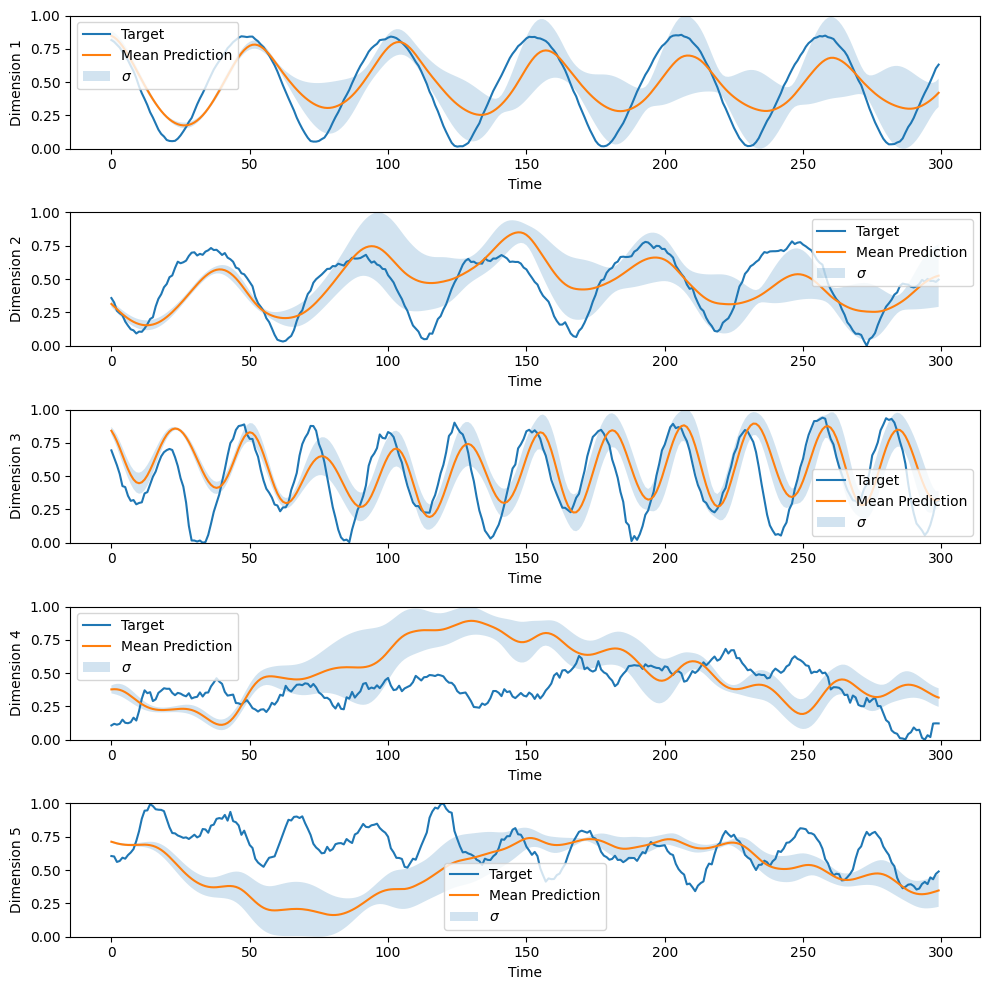

In [12]:
num_dimensions = mean_test_truths.shape[1]
# Create subplots
fig, axs = plt.subplots(num_dimensions, 1, figsize=(10, 10))

# Iterate over each dimension
for dim in range(num_dimensions):
    # Extract arrays for the current dimension
    target_dim = mean_test_truths[:, dim]
    out_dim = mean_test_predictions[:, dim]
    std_dim = std_test_predictions[:, dim]

    # Calculate min and max values across all arrays for current dimension
    data_min = min(np.min(target_dim), np.min(out_dim - std_dim))
    data_max = max(np.max(target_dim), np.max(out_dim + std_dim))

    # Normalize arrays to [0, 1] range
    target_dim = (target_dim - data_min) / (data_max - data_min)
    out_dim = (out_dim - data_min) / (data_max - data_min)
    std_dim = std_dim / (data_max - data_min)  # std deviation is normalized accordingly

    # Plot target and output arrays
    axs[dim].plot(target_dim, label='Target')
    axs[dim].plot(out_dim, label='Mean Prediction')
    axs[dim].fill_between(range(len(out_dim)), out_dim - std_dim, out_dim + std_dim, alpha=0.2, label=r'$\sigma$')

    # Set y-axis limits to [0, 1]
    axs[dim].set_ylim(0, 1)

    # Add labels and legend
    axs[dim].set_xlabel('Time')
    axs[dim].set_ylabel(f'Dimension {dim + 1}')
    axs[dim].legend()

# Add title
#plt.suptitle('Target and Mean Prediction for Each Dimension on test data, for top 5 models of LSTM')
# Adjust layout
plt.tight_layout()

# Plot frequency
plt.show()

## Reconstruction of Temperature map along and error analysis

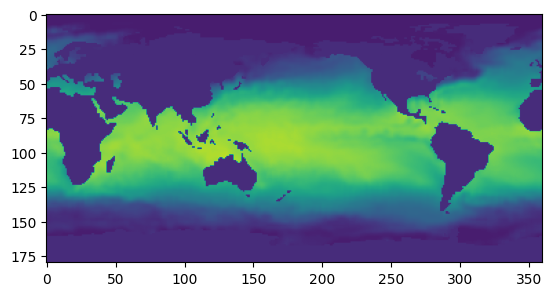

In [13]:
train_data = np.load('Data/sst_var_train',allow_pickle=True).data
test_data = np.load('Data/sst_var_test',allow_pickle=True).data
mask = np.load('Data/mask',allow_pickle=True)
#plt.imshow(train_data[0]*mask[0],vmin=-5,vmax=35)
plt.imshow(test_data[0]*mask[0],vmin=-5,vmax=35)

In [14]:
train_data_ml = train_data.reshape(427,180*360)
mask = mask[0].flatten()
mask = np.asarray(mask,dtype='bool')

train_data_ml = train_data_ml[:,mask]
train_data_ml.shape

# Find train data mean
train_data_mean = np.mean(train_data_ml,axis=0)
train_data_ml = train_data_ml - train_data_mean[None,]

In [15]:
test_data_ml = test_data.reshape(1487,180*360)
mask = np.load('Data/mask',allow_pickle=True)
mask = mask[0].flatten()
mask = np.asarray(mask,dtype='bool')

test_data_ml = test_data_ml[:,mask]
test_data_ml.shape

# Find train data mean
test_data_mean = np.mean(test_data_ml,axis=0)
test_data_ml = test_data_ml - test_data_mean[None,]

In [16]:
def field_compression(Y,K):
    '''
    Y - Snapshot matrix - shape: NxS
    K - number of modes to truncate to
    returns 
    V - truncated POD basis matrix - shape: NxK
    Ytilde - truncated coefficient matrix - shape: KxS
    '''
    V = generate_pod_bases(Y,K)
    Ytilde = field_coefficients(Y,V)

    return V, Ytilde

def generate_pod_bases(Y,K): #Mean removed
    '''
    Y - Snapshot matrix - shape: NxS
    returns V - truncated POD basis matrix - shape: NxK
    '''
    new_mat = np.matmul(np.transpose(Y),Y)
    w,v = np.linalg.eig(new_mat)

    # plt.figure()
    # plt.semilogy(w[:]/np.sum(w)*100)
    # plt.show()

    # Bases
    V = np.real(np.matmul(Y,v)) 
    trange = np.arange(np.shape(V)[1])
    V[:,trange] = V[:,trange]/np.sqrt(w[:])

    # Truncate phis
    V = V[:,0:K] # Columns are modes

    return V

def field_coefficients(Y,V):
    '''
    Y - Snapshot matrix - shape: NxS
    V - truncated POD basis matrix - shape: NxK
    returns Ytilde - shape: KxS
    '''
    return np.matmul(np.transpose(V),Y)

In [17]:
modes, coeffs = field_compression(train_data_ml.T,5)
modes_test, coeffs_test = field_compression(test_data_ml.T,5)

c:\Users\Vinamr J\Documents\qic\qrc\hqr\hqr-master\chaos\hqr2-venv\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in sqrt


In [18]:
N_train=427
with open("./Data/testing_data_N{:d}.pickle".format(N_train), "rb") as file:
    data = pickle.load(file)
    data_test = data["test_input_sequence"]
    del data
with open("./Data/training_data_N{:d}.pickle".format(N_train), "rb") as file:
    data = pickle.load(file)
    data_train = data["train_input_sequence"]
    del data

In [19]:
np.allclose(data_train[116+300-1],targets_train[samples[0]][299])
#check

True

In [20]:
print(data_train[116+300-1])
print(mean_train_truths[299])
print(mean_train_predictions[299])
#check

[321.8648    -99.581604  -48.89029    -8.7071905  -2.9636319]
[321.8648    -99.581604  -48.890293   -8.7071905  -2.9636319]
[407.96045813 -78.71121681 -20.08734898  18.33031864 -41.82685776]


In [21]:
test_ic = [116,40,66] #taken from randomly generated test indices from the data_analysis.ipynb file
pl_max = 300
dl_max = test_ic[0]
recon_data_ml = np.matmul(modes,data_train[test_ic[0]:test_ic[0]+pl_max].T).T
recon_data_ml = recon_data_ml + train_data_mean[None,]
recon_data = np.copy(train_data[test_ic[0]:test_ic[0]+pl_max])
recon_data = recon_data.reshape(pl_max,180*360)
recon_data[:,mask] = recon_data_ml
recon_data = recon_data.reshape(pl_max,180,360)

pred_data_ml = np.matmul(modes,mean_train_predictions.T).T
pred_data_ml = pred_data_ml + train_data_mean[None,]
pred_data = np.copy(train_data[test_ic[0]:test_ic[0]+pl_max])
pred_data = pred_data.reshape(pl_max,180*360)
pred_data[:,mask] = pred_data_ml
pred_data = pred_data.reshape(pl_max,180,360)
new_mask = np.load('Data/mask',allow_pickle=True)
#check if correctly done

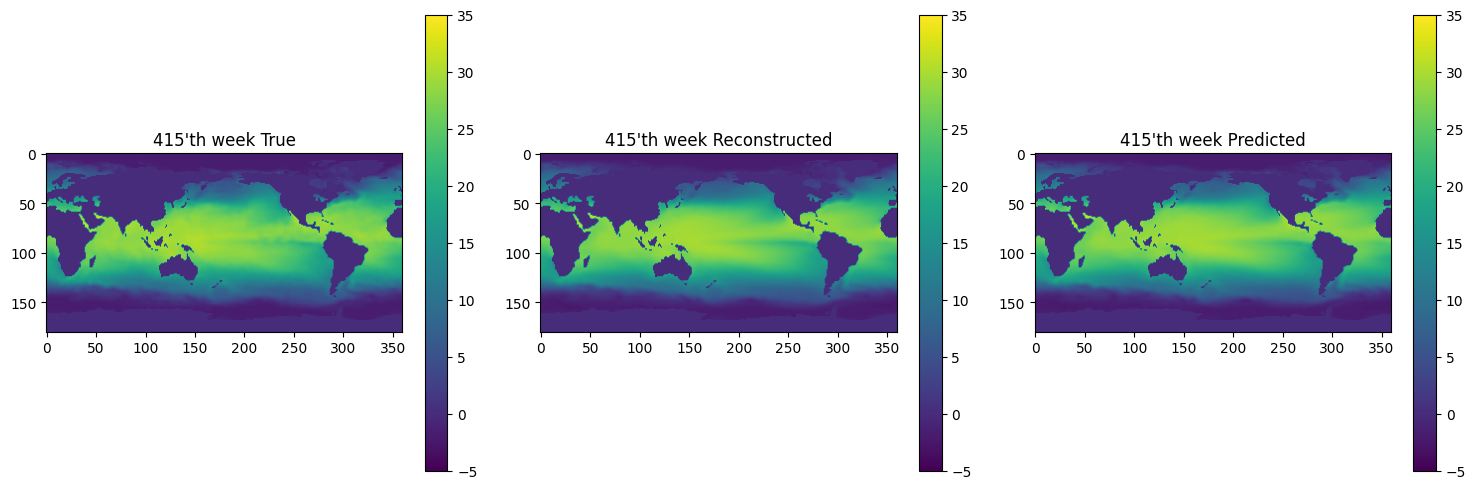

In [22]:
# Create a single figure and subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot the first subplot
im1 = axs[0].imshow(train_data[dl_max+pl_max-1] * new_mask[0], vmin=-5, vmax=35)
axs[0].set_title("{}'th week True".format(dl_max+pl_max-1))
fig.colorbar(im1, ax=axs[0], orientation='vertical')


# Plot the second subplot
im2 = axs[1].imshow(recon_data[pl_max-1] * new_mask[0], vmin=-5, vmax=35)
axs[1].set_title("{}'th week Reconstructed".format(dl_max+pl_max-1))
fig.colorbar(im2, ax=axs[1], orientation='vertical')

# Plot the third subplot
im3 = axs[2].imshow(pred_data[pl_max-1] * new_mask[0], vmin=-5, vmax=35)
axs[2].set_title("{}'th week Predicted".format(dl_max+pl_max-1))
fig.colorbar(im3, ax=axs[2], orientation='vertical')

# Adjust layout
plt.tight_layout()

# Show the figure
plt.show()

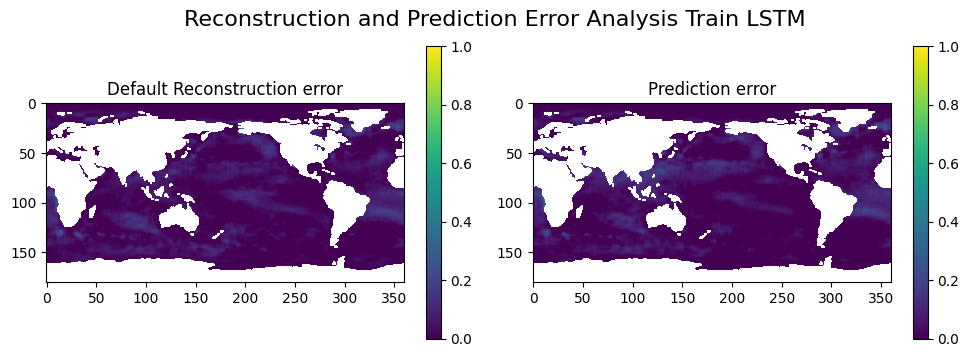

In [23]:
# Create a single figure and subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plot the first subplot
masked_recon_error = np.ma.array(np.mean(train_data[dl_max:dl_max+pl_max]-recon_data,axis=0), mask=new_mask[0] == 0)
im1 = axs[0].imshow(masked_recon_error, vmin=0.0, vmax=1)
axs[0].set_title("Default Reconstruction error")
fig.colorbar(im1, ax=axs[0], orientation='vertical', shrink=0.5)  # Shrink the color bar

# Plot the second subplot
masked_pred_error = np.ma.array(np.mean(train_data[dl_max:dl_max+pl_max]-pred_data,axis=0), mask=new_mask[0] == 0)
im2 = axs[1].imshow(masked_pred_error, vmin=0.0, vmax=1)
axs[1].set_title("Prediction error")  # 415th week prediction error (dl_max+pl_max-1)
fig.colorbar(im2, ax=axs[1], orientation='vertical', shrink=0.5)  # Shrink the color bar

# Add a title to the entire figure
fig.suptitle('Reconstruction and Prediction Error Analysis Train LSTM', fontsize=16)

# Adjust layout
plt.tight_layout()

# Adjust layout to make room for the figure title
plt.subplots_adjust(top=1.2)  # Adjust the top to make room for suptitle

# Show the figure
plt.show()

In [24]:
recon_train = recon_data
pred_grid_train = pred_data

In [25]:
temp_true = train_data[dl_max:dl_max+pl_max]
rmse_pred = np.sqrt(np.mean((temp_true-pred_data)**2))
print(rmse_pred)

0.5285722


## For East Pacific Region

In [26]:
temp_true_ep = train_data[dl_max:dl_max+pl_max,80:100,200:250]
temp_pred_ep = pred_data[:,80:100,200:250]
rmse_pred = np.sqrt(np.mean((temp_true_ep-temp_pred_ep)**2))
print(rmse_pred)

0.73177546


## For test data

In [27]:
test_ic = [116,40,66] #taken from randomly generated test indices from the data_analysis.ipynb file
pl_max = 300
dl_max = test_ic[0]
recon_data_ml = np.matmul(modes_test,data_test[test_ic[0]:test_ic[0]+pl_max].T).T
recon_data_ml = recon_data_ml + test_data_mean[None,]
recon_data = np.copy(test_data[test_ic[0]:test_ic[0]+pl_max])
recon_data = recon_data.reshape(pl_max,180*360)
recon_data[:,mask] = recon_data_ml
recon_data = recon_data.reshape(pl_max,180,360)

pred_data_ml = np.matmul(modes_test,mean_test_predictions.T).T
pred_data_ml = pred_data_ml + test_data_mean[None,]
pred_data = np.copy(test_data[test_ic[0]:test_ic[0]+pl_max])
pred_data = pred_data.reshape(pl_max,180*360)
pred_data[:,mask] = pred_data_ml
pred_data = pred_data.reshape(pl_max,180,360)
new_mask = np.load('Data/mask',allow_pickle=True)
#check if correctly done

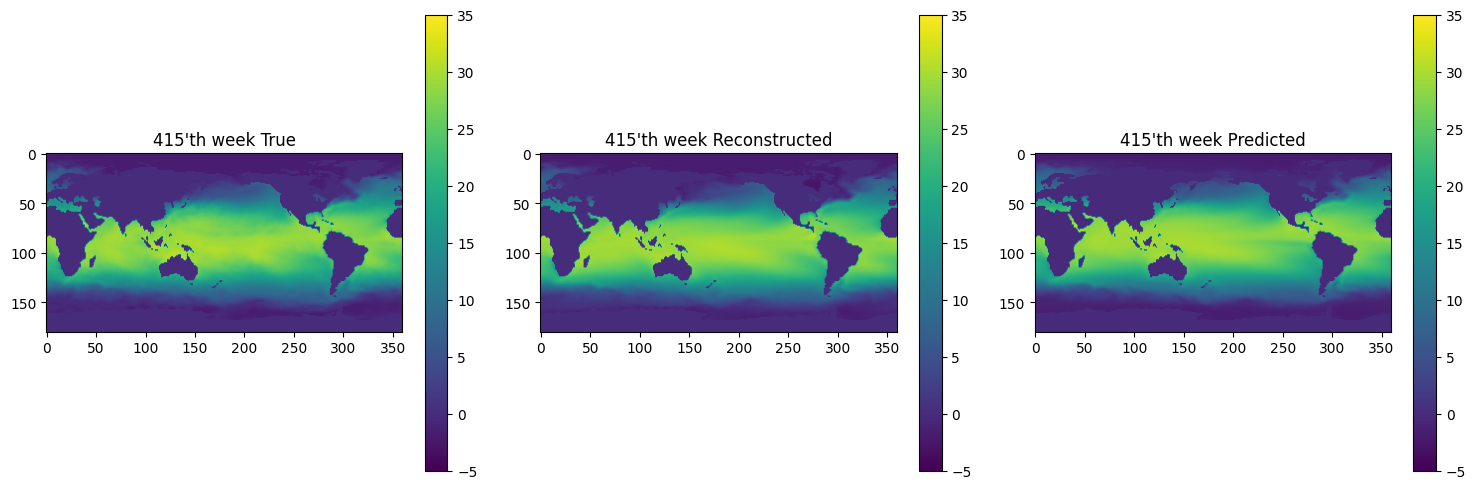

In [28]:
# Create a single figure and subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot the first subplot
im1 = axs[0].imshow(test_data[dl_max+pl_max-1] * new_mask[0], vmin=-5, vmax=35)
axs[0].set_title("{}'th week True".format(dl_max+pl_max-1))
fig.colorbar(im1, ax=axs[0], orientation='vertical')


# Plot the second subplot
im2 = axs[1].imshow(recon_data[0] * new_mask[0], vmin=-5, vmax=35)
axs[1].set_title("{}'th week Reconstructed".format(dl_max+pl_max-1))
fig.colorbar(im2, ax=axs[1], orientation='vertical')

# Plot the third subplot
im3 = axs[2].imshow(pred_data[pl_max-1] * new_mask[0], vmin=-5, vmax=35)
axs[2].set_title("{}'th week Predicted".format(dl_max+pl_max-1))
fig.colorbar(im3, ax=axs[2], orientation='vertical')

# Adjust layout
plt.tight_layout()

# Show the figure
plt.show()

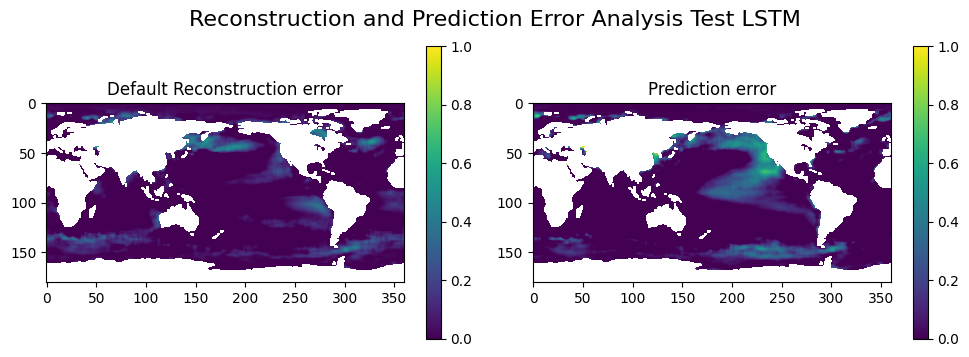

In [29]:
# Create a single figure and subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plot the first subplot
masked_recon_test_error = np.ma.array(np.mean(test_data[dl_max:dl_max+pl_max]-recon_data,axis=0),mask=new_mask[0]==0)
im1 = axs[0].imshow(masked_recon_test_error, vmin=0.0, vmax=1)
axs[0].set_title("Default Reconstruction error")
fig.colorbar(im1, ax=axs[0], orientation='vertical', shrink=0.5)

# Plot the second subplot
masked_pred_test_error = np.ma.array(np.mean(test_data[dl_max:dl_max+pl_max]-pred_data,axis=0),mask=new_mask[0]==0)
im2 = axs[1].imshow(masked_pred_test_error, vmin=0.0, vmax=1)
axs[1].set_title("Prediction error")
fig.colorbar(im2, ax=axs[1], orientation='vertical', shrink=0.5)

fig.suptitle('Reconstruction and Prediction Error Analysis Test LSTM', fontsize=16)

# Adjust layout
plt.tight_layout()

# Adjust layout to make room for the figure title
plt.subplots_adjust(top=1.2)  # Adjust the top to make room for suptitle

In [30]:
recon_test = recon_data
pred_grid_test = pred_data

In [31]:
temp_true = test_data[dl_max:dl_max+pl_max]
rmse_pred = np.sqrt(np.mean((temp_true-pred_data)**2))
print(rmse_pred)

1.0949336


## For East Pacific Region

In [32]:
temp_true_ep = test_data[dl_max:dl_max+pl_max,80:100,200:250]
temp_pred_ep = pred_data[:,80:100,200:250]
rmse_pred = np.sqrt(np.mean((temp_true_ep-temp_pred_ep)**2))
print(rmse_pred)

1.2586342


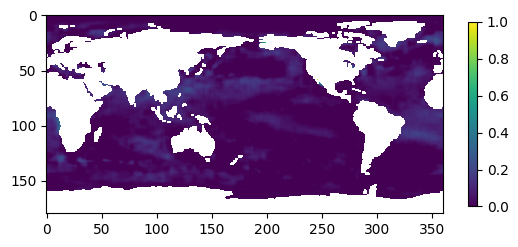

In [33]:
masked_pred_train_error = np.ma.array(np.mean(train_data[dl_max:dl_max+pl_max]-pred_grid_train,axis=0),mask=new_mask[0]==0)
plt.figure()
im1 = plt.imshow(masked_pred_train_error, vmin=0.0, vmax=1)
#plt.title("HQRC Average Prediction Error Train")
plt.colorbar(im1, orientation='vertical', shrink=0.5)

# Show the plot
plt.show()

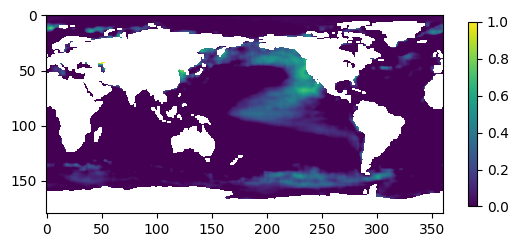

In [34]:
masked_pred_test_error = np.ma.array(np.mean(test_data[dl_max:dl_max+pl_max]-pred_grid_test,axis=0),mask=new_mask[0]==0)
plt.figure()
im1 = plt.imshow(masked_pred_test_error, vmin=0.0, vmax=1)
#plt.title("HQRC Average Prediction Error Test")
plt.colorbar(im1, orientation='vertical', shrink=0.5)

# Show the plot
plt.show()

## Memory and computation time analysis

In [35]:
models = []
samples = []
size_values = [80,120,250,500,1000,2000]
layer_values = [1,2]
hspl_values = [50,60,70]
sl_values = [16,20]
for size in size_values:
    for layers in layer_values:
        for hspl in hspl_values:
            for sl in sl_values:
                string1 = f"RNN-lstm-RDIM_5-N_used_427-NLAY_{layers}-SLAY_{size}-ISH_statefull-SL_{sl}-PL_{sl}-LR_0.001-DKP_1.0-ZKP_1.0-HSPL_{hspl}-IPL_300-NL_0-NICS_3"
                string2 = f"LSTM-{size}-({layers})-HSPL-{hspl}-SL-{sl}"
                models.append([os.path.join(model_path,string1),string2])
                samples.append(string2)
title = "Sea Surface Temperatures"

In [36]:
train_time_dict = dict()
memory_dict = dict()
trainable_parameters_dict = dict()
for i in range(len(models)):
    rfolder, label = models[i][0], models[i][1]
    fname = os.path.join(rfolder, 'data.pickle')
    if os.path.isfile(fname):
        with open(fname, 'rb') as rfile:
            try:
                rs = pickle.load(rfile)
            except:
                continue
            #print(rs.keys())
            train_time_dict[label]=rs["total_training_time"]
            trainable_parameters_dict[label]=rs["n_trainable_parameters"]
            memory_dict[label]=rs["memory"]
    else:
        print('Not found {}'.format(fname))

In [37]:
train_time_dict

{'LSTM-80-(1)-HSPL-50-SL-16': 89.24563884735107,
 'LSTM-80-(1)-HSPL-50-SL-20': 45.26753067970276,
 'LSTM-80-(1)-HSPL-60-SL-16': 86.6607301235199,
 'LSTM-80-(1)-HSPL-60-SL-20': 106.96041321754456,
 'LSTM-80-(1)-HSPL-70-SL-16': 92.65801191329956,
 'LSTM-80-(1)-HSPL-70-SL-20': 130.98010158538818,
 'LSTM-80-(2)-HSPL-50-SL-16': 103.95362448692322,
 'LSTM-80-(2)-HSPL-50-SL-20': 119.9335081577301,
 'LSTM-80-(2)-HSPL-60-SL-16': 233.96761894226074,
 'LSTM-80-(2)-HSPL-60-SL-20': 135.02175211906433,
 'LSTM-80-(2)-HSPL-70-SL-16': 16.250502347946167,
 'LSTM-80-(2)-HSPL-70-SL-20': 179.4533052444458,
 'LSTM-120-(1)-HSPL-50-SL-16': 72.32846546173096,
 'LSTM-120-(1)-HSPL-50-SL-20': 91.23176097869873,
 'LSTM-120-(1)-HSPL-60-SL-16': 111.72890067100525,
 'LSTM-120-(1)-HSPL-60-SL-20': 124.15603160858154,
 'LSTM-120-(1)-HSPL-70-SL-16': 103.72971653938293,
 'LSTM-120-(1)-HSPL-70-SL-20': 32.536850690841675,
 'LSTM-120-(2)-HSPL-50-SL-16': 78.69014716148376,
 'LSTM-120-(2)-HSPL-50-SL-20': 187.19719576835632,
 '

In [38]:
values = train_time_dict.values()
total = sum(values)
average = total / len(values)
print(average)

770.8638255662388


In [39]:
memory_dict

{'LSTM-80-(1)-HSPL-50-SL-16': 434.671875,
 'LSTM-80-(1)-HSPL-50-SL-20': 434.0859375,
 'LSTM-80-(1)-HSPL-60-SL-16': 433.1796875,
 'LSTM-80-(1)-HSPL-60-SL-20': 432.70703125,
 'LSTM-80-(1)-HSPL-70-SL-16': 434.125,
 'LSTM-80-(1)-HSPL-70-SL-20': 433.5859375,
 'LSTM-80-(2)-HSPL-50-SL-16': 515.21484375,
 'LSTM-80-(2)-HSPL-50-SL-20': 514.859375,
 'LSTM-80-(2)-HSPL-60-SL-16': 508.8359375,
 'LSTM-80-(2)-HSPL-60-SL-20': 506.546875,
 'LSTM-80-(2)-HSPL-70-SL-16': 355.38671875,
 'LSTM-80-(2)-HSPL-70-SL-20': 516.8359375,
 'LSTM-120-(1)-HSPL-50-SL-16': 440.7890625,
 'LSTM-120-(1)-HSPL-50-SL-20': 439.52734375,
 'LSTM-120-(1)-HSPL-60-SL-16': 438.53125,
 'LSTM-120-(1)-HSPL-60-SL-20': 439.59765625,
 'LSTM-120-(1)-HSPL-70-SL-16': 439.375,
 'LSTM-120-(1)-HSPL-70-SL-20': 437.48828125,
 'LSTM-120-(2)-HSPL-50-SL-16': 532.625,
 'LSTM-120-(2)-HSPL-50-SL-20': 531.7265625,
 'LSTM-120-(2)-HSPL-60-SL-16': 517.69140625,
 'LSTM-120-(2)-HSPL-60-SL-20': 533.15625,
 'LSTM-120-(2)-HSPL-70-SL-16': 535.671875,
 'LSTM-120-(2

In [40]:
values = memory_dict.values()
total = sum(values)
average = total / len(values)
print(average)

1179.0142686631943


In [41]:
trainable_parameters_dict

{'LSTM-80-(1)-HSPL-50-SL-16': 27925,
 'LSTM-80-(1)-HSPL-50-SL-20': 27925,
 'LSTM-80-(1)-HSPL-60-SL-16': 27925,
 'LSTM-80-(1)-HSPL-60-SL-20': 27925,
 'LSTM-80-(1)-HSPL-70-SL-16': 27925,
 'LSTM-80-(1)-HSPL-70-SL-20': 27925,
 'LSTM-80-(2)-HSPL-50-SL-16': 79445,
 'LSTM-80-(2)-HSPL-50-SL-20': 79445,
 'LSTM-80-(2)-HSPL-60-SL-16': 79445,
 'LSTM-80-(2)-HSPL-60-SL-20': 79445,
 'LSTM-80-(2)-HSPL-70-SL-16': 79445,
 'LSTM-80-(2)-HSPL-70-SL-20': 79445,
 'LSTM-120-(1)-HSPL-50-SL-16': 61085,
 'LSTM-120-(1)-HSPL-50-SL-20': 61085,
 'LSTM-120-(1)-HSPL-60-SL-16': 61085,
 'LSTM-120-(1)-HSPL-60-SL-20': 61085,
 'LSTM-120-(1)-HSPL-70-SL-16': 61085,
 'LSTM-120-(1)-HSPL-70-SL-20': 61085,
 'LSTM-120-(2)-HSPL-50-SL-16': 176765,
 'LSTM-120-(2)-HSPL-50-SL-20': 176765,
 'LSTM-120-(2)-HSPL-60-SL-16': 176765,
 'LSTM-120-(2)-HSPL-60-SL-20': 176765,
 'LSTM-120-(2)-HSPL-70-SL-16': 176765,
 'LSTM-120-(2)-HSPL-70-SL-20': 176765,
 'LSTM-250-(1)-HSPL-50-SL-16': 257255,
 'LSTM-250-(1)-HSPL-50-SL-20': 257255,
 'LSTM-250-(1)-H